# 3D Rigid Body Motion

## Using Numpy/Scipy as a replacement for Eigen

In [2]:
import numpy as np

### Basic Matrix Ops

In [3]:
m = np.random.randn(3,3)
print(f"Transpose = {m.T}")
print(f"\nSum: {m.sum()}")
print(f"Trace: {m.trace()}")
print(f"\nScalar multiplication: {m * 10}")
print(f"\nInverse matrix: {np.linalg.inv(m)}") # <- Computed inverse using LU factorisation
print(f"\nDeterminant: {np.linalg.det(m)}")

Transpose = [[ 0.25946564 -0.19871556 -0.46530025]
 [-0.66778174  0.45052317 -0.38070515]
 [ 1.9367185   1.2235278  -1.5337157 ]]

Sum: 0.6240167134952361
Trace: -0.8237268929768999

Scalar multiplication: [[  2.59465636  -6.6778174   19.36718504]
 [ -1.98715563   4.50523171  12.23527805]
 [ -4.6530025   -3.80705149 -15.337157  ]]

Inverse matrix: [[-0.20892136 -1.63438471 -1.56765495]
 [-0.8110018   0.46689436 -0.65163574]
 [ 0.26469294  0.3799469  -0.01466287]]

Determinant: 1.0777793246131


In [4]:
# Eigen values
s = m.T @ m # construct a real symmetric matrix: A^T A
eigVals, eigVecs = np.linalg.eigh(s) # `eigh` is optimised for symmetric matrices, compared to the generalist `eig`
print(f"Eigen Values: {eigVals}")
print(f"Eigen Vectors: {eigVecs}")

Eigen Values: [0.18857985 0.79664788 7.73210958]
Eigen Vectors: [[ 0.9861639  -0.10228981  0.13045134]
 [ 0.10630882  0.99403844 -0.0242076 ]
 [-0.12719746  0.03774079  0.99115914]]


In [5]:
# Solving Equations
sz = 100
A = np.random.randn(sz, sz)
A = A @ A.T # Make `A` into a positive semi-definite matrix (x^T.M.x >= 0) by representing it as a symmetric matrix
b = np.random.randn(sz)
# By positive semi-definiteness, `b.T @ A @ b` >= 0

In [6]:
# by direct inversion using LU factorisation
x = np.linalg.inv(A) * b
print(f"Condition number for A: {np.linalg.cond(A)}, (could be worse)")
print(np.linalg.norm(x))

Condition number for A: 17403017.153297648, (could be worse)
45196.356343043764


In [7]:
# QR decomposition
import scipy
def qr_solve(A, b):
    Q, R = np.linalg.qr(A)
    # Q is orthonormal, therefore, its transpose is also its inverse
    p = Q.T @ b
    Rinv = np.linalg.inv(R) # can't be bothered to solve directly using upper triangular R structure
    return Rinv @ p
    # return scipy.linalg.solve_triangular(R, p)

x = qr_solve(A, b)
print(np.linalg.norm(x)) # <- norm is much lower here, QR decomp is much more stable and accurate

43450.58191224543


In [8]:
# Cholesky decomp
L = np.linalg.cholesky(A)
y = np.linalg.solve(L, b)
x = np.linalg.solve(L.T, y)
print(np.linalg.norm(x))

43450.581898553086


## Replicating Eigen Geometry with Numpy/Scipy

In [9]:
from scipy.spatial.transform import Rotation as R

In [10]:
id_rot = R.identity()
print(id_rot.as_matrix())
print(id_rot.as_quat()) # scalar last format
print(id_rot.as_rotvec())

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[0. 0. 0. 1.]
[0. 0. 0.]


In [11]:
# Axis Angle Representation
rotvec = R.from_euler('z', np.pi/4) # 45 degree rotation along the z-axis
print(rotvec.as_matrix)

v = np.array([1, 0, 0])
v_rotated = rotvec.apply(v)
print(v_rotated)

<bound method Rotation.as_matrix of <scipy.spatial.transform._rotation.Rotation object at 0x116770f30>>
[0.70710678 0.70710678 0.        ]


In [12]:
from Transforms import Transform

T = Transform.identity()

T.rotate(rotvec)
# T.pretranslate(np.array([1, 3, 4]))

v = np.array([1, 0, 0])
v_rot = T * v
print(v_rot)

[0.70710678 0.70710678 0.        ]


In [13]:
q = rotvec
v_rot = q.apply(v)
print(v_rot)

[0.70710678 0.70710678 0.        ]


In [14]:
# Coordinate transformation example
# No need to normalise raw initial values as scipy would perform the normalisation
P1 = Transform(R.from_quat([0.2, 0.3, 0.1, 0.35]), np.array([0.3, 0.1, 0.1]))
P2 = Transform(R.from_quat([0.4, -0.1, 0.2, -0.5]), np.array([-0.1, 0.5, 0.3]))

ptP1 = np.array([0.5, 0, 0.2, 1]) # Added trailing `1` to make it homogeneous

ptWorldOrigin = P1.inv() @ ptP1 # `P1.inv()` is the transform from robot 1 to the world coordinates
ptP2 = P2 * ptWorldOrigin
print(f"Point in robot 2's coordinate:\n{ptP2}")


Point in robot 2's coordinate:
[-0.03097308  0.73498965  0.29610766  1.        ]


## Trajectory Plotting

Download txt file from `https://github.com/gaoxiang12/slambook2/blob/master/ch3/examples/trajectory.txt`

In [15]:
lines = np.loadtxt("./resources/trajectory.txt")

# The trajectories are in the world to robot format (i think)
numPoints = lines.shape[0]
data = []
for i in range(numPoints):
    time = lines[i, 0]
    t = lines[i,1:4]
    q = lines[i, 4:] # quaternions are already in the scalar last format
    T = Transform(R.from_quat(q), t)
    data.append((time, T))

# data is a list of tuples of (time, transform)

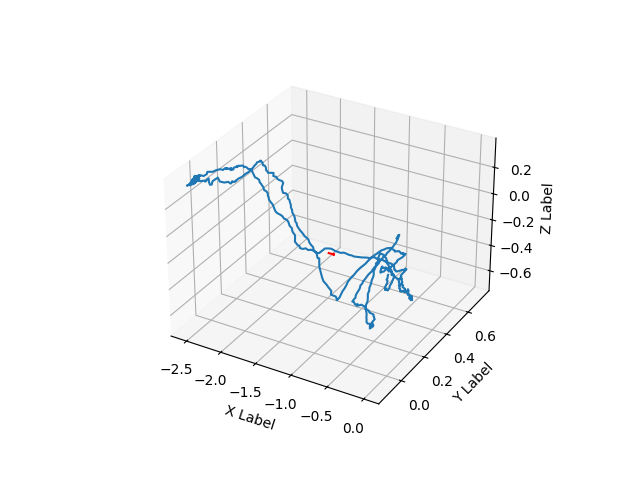

In [30]:
import matplotlib.pyplot as plt

# Ensure the required backend is installed using `pip install ipympl`
%matplotlib widget 

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(lines[:,1], lines[:,2], lines[:,3])

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# TODO: Draw the axes of each pose
ax.quiver(
    -1.5, 0.4, -0.4,
    0.1, 0, 0,
    color='red', length=0.1, normalize=True
)

plt.show()

%matplotlib inline